# Configs

In [1]:
train_path = "../datasets/utn_dataset_curated/part2/train"
val_path = "../datasets/utn_dataset_curated/part2/val"
batch_size = 2

# Dataset
This is just a simple dataset and dataloader, will be replaced by the proper dataloader later

In [2]:
from torchvision.datasets import VisionDataset
import torch
import os
from pathlib import Path
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import torch.utils.data as data
import torchvision.transforms as T
class CaptchaDatasetUTN(VisionDataset):
    def __init__(self, data_path: str,
                 img_transform=None,
                 target_transform=None,):
        super(CaptchaDatasetUTN).__init__()
        self.img_transform = img_transform
        self.target_transform = target_transform
        self.data_path = data_path
        self.img_paths = self._get_paths(data_path, suffix="/images/")
        self.ann_paths = self._get_paths(data_path, suffix="/labels/")
        # we hardcode the following values for the UTN dataset
        self.img_height, self.img_width = 160, 640

    @staticmethod
    def _get_paths(data_path, suffix):
        img_path =  data_path + suffix
        assert os.path.exists(img_path), f"{img_path} does not exist!"
        file_list = list(Path(img_path).glob('**/*'))
        file_names = [p for p in file_list if p.is_file()]
        file_names = sorted(file_names, key=lambda x: int(str(x).split("/")[-1].split(".")[0]))
        return file_names

    def __getitem__(self, idx: int) -> list[tuple[torch.Tensor, torch.Tensor]]:
        if idx >= len(self) or idx < 0:
            # needed for iterator stop condition
            raise IndexError(f"{self.data_path} has {len(self)} files!")
        factor = 4
        img_path = str(self.img_paths[idx])
        mu, std = (137.71044921875, 60.335174560546875)
        # for some reason, the provided dataset has four channels
        img = read_image(f'{img_path}')[:3, :, :].to(dtype=torch.float32)
        img = T.Normalize((-mu), (1/std))(img)
        img = T.Grayscale()(img)
        h, w = img.shape[-2: ]
        size=(h//factor, w//factor)
        img = T.Resize(size, antialias=False)(img)
        img = img
        
        assert img.size(0) == 1, f"invalid channels in gray image: {img.shape}"
        if self.img_transform:
            img = self.img_transform(img)
        assert isinstance(img, torch.Tensor), f"got transformed img of type{type(img)}!"
        with open(f"{self.ann_paths[idx]}", "r") as fo:
            ann = []
            for line in fo:
                ann.append(line.split())
        count = 0
        for obj in ann:
            count += 1
        # transform bounding boxes
        if self.target_transform is not None:
            bboxes = self.target_transform(bboxes)
        return img, count
    
    def __len__(self) -> int:
        return len(self.img_paths)
        
    def show(self, imgs, title=""):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        plt.title(title)
        for i, img in enumerate(imgs):
            # img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

sample_img_batch.shape = torch.Size([2, 1, 40, 160])
sample_count_batch[img_num] = tensor(4)


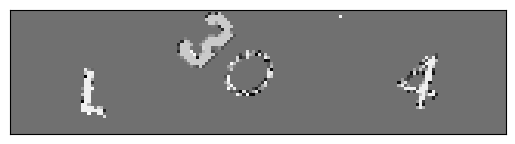

In [3]:
# dataset
train_set = CaptchaDatasetUTN(data_path=train_path, img_transform=None, target_transform=None)
val_set = CaptchaDatasetUTN(data_path=val_path, img_transform=None, target_transform=None)

#dataloader
train_loader = data.DataLoader(train_set, batch_size=batch_size)
val_loader = data.DataLoader(val_set, batch_size=batch_size)
sample_img_batch,  sample_count_batch = next(iter(train_loader))
print(f"{sample_img_batch.shape = }")
img_num = 0
train_set.show(sample_img_batch[img_num])
print(f"{sample_count_batch[img_num] = }")



In [5]:
import torch
import torch.nn as nn

class CountBackbone(nn.Module):
    def __init__(self, input_channels=1, nr_filters=16, kernel_size=3):
        super(CountBackbone, self).__init__()
        # single conv layer for now
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                        out_channels=nr_filters, 
                        kernel_size=kernel_size, 
                        stride=1, 
                        padding=1)

        # fully connected layer ( for regression ) outputs character count
        self.fc = nn.Linear(nr_filters, 1)

    def forward(self, x):
        # apply convolution
        x = self.conv1(x) 
        # activation function
        x = F.relu(x)
        # global avg pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # flatten for the fuly  connected layer
        x = torch.flatten(x, 1)
        # output 
        x = self.fc(x)





In [6]:
model = CountBackbone()
print(model)

CountBackbone(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
